#**5.5.1 Digit classification using DRNN (Pytorch)**#



---



This example illustrates the implementation of Deep Recurrent Neural Networks (DeepRNN) in PyTorch. Here the DeepRNN model is built for digit classification using MNIST dataset.  

###**Importing packages and setting the parameters**###

The first step consists of importing the PyTorch libraries and other necessary packages.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Hyperparameters
input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 3
num_classes = 10
batch_size = 100
num_epochs = 5
learning_rate = 0.001


###**Loading the dataset**###

The DeepRNN in this example employs the MNIST dataset for performing the classification task. It is a commonly used dataset in machine learning for digit recognition applications and it is an inbuilt dataset in PyTorch. The dataset consists of 70,000 grayscale images of hand-written digits (0-9), with 60,000 images in the training set and 10,000 in the test set.

In [3]:
# MNIST dataset
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9858112.30it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 412587.51it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3834620.47it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



###**DeepRNN model architecture**###

The DeepRNN architecture represented by the code has more than 1 recurrent layer and it uses the default activation function, which is the hyperbolic tangent (tanh) function. The RNN is followed by a fully connected layer which takes the last hidden state of the RNN and maps it to the number of output classes. In this example we use 3 recurrent layers and 1 dense layer.

The input tensor is assumed to be of shape (batch_size, sequence_length, input_size) where:

*   batch_size= the number of sequences in a batch
*   sequence_length= length of each sequence
*   input_size = number of features at each time step

The output tensor is of shape (batch_size, num_classes), where num_classes is the number of output classes.



In [4]:
# Recurrent neural network
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DeepRNN, self).__init__()
        self.hidden_size = hidden_size # the number of features in the hidden state h.
        self.num_layers = num_layers #the number of recurrent layers.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)# Initialize hidden state with zeros
        out, _ = self.rnn(x, h0)  # Forward propagate RNN
        out = self.fc(out[:, -1, :]) # Decode the hidden state of the last time step
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepRNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

DeepRNN(
  (rnn): RNN(28, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


###**Training of the DeepRNN**###

We construct a nested for loop for training. The outer loop iterates over the number of epochs whereas the inner loop iterates over each batch of image-label pairs. The DeepRNN is trained on a set of image-label pairs using the cross-entropy loss criterion and the Adam optimizer.  Next, the forward pass of the model is performed on the input images to obtain the predicted outputs and the cross-entropy loss function calculates the loss between the predicted and actual labels. Following this, the backward pass is performed to compute the gradients of the loss with respect to the parameters of the model. Later the optimizer is updated to adjust the parameters of the model based on the computed gradients.


In [5]:
#Initialize the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device) #The input images are reshaped to match the input size of the model, and then they are moved to the device (CPU or GPU) for processing.
        labels = labels.to(device) # Move the labels to the device (CPU or GPU) for processing.
        outputs = model(images) # Forward pass through the model to predict the output.
        loss = criterion(outputs, labels) # Calculate the loss between actual and predicted labels
        optimizer.zero_grad() # Set the gradients to zero to prevent them from accumulating between batches.
        loss.backward() #Compute the gradients during backpropagation.
        optimizer.step() # Update the optimizer to adjust the parameters of the model based on the computed gradients.

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item())) # Print the current epoch, step, and loss at every 100 iterations.

Epoch [1/5], Step [100/600], Loss: 0.9092
Epoch [1/5], Step [200/600], Loss: 0.4167
Epoch [1/5], Step [300/600], Loss: 0.3738
Epoch [1/5], Step [400/600], Loss: 0.3655
Epoch [1/5], Step [500/600], Loss: 0.2551
Epoch [1/5], Step [600/600], Loss: 0.2754
Epoch [2/5], Step [100/600], Loss: 0.4567
Epoch [2/5], Step [200/600], Loss: 0.2982
Epoch [2/5], Step [300/600], Loss: 0.2328
Epoch [2/5], Step [400/600], Loss: 0.2487
Epoch [2/5], Step [500/600], Loss: 0.0945
Epoch [2/5], Step [600/600], Loss: 0.1467
Epoch [3/5], Step [100/600], Loss: 0.2001
Epoch [3/5], Step [200/600], Loss: 0.1611
Epoch [3/5], Step [300/600], Loss: 0.2312
Epoch [3/5], Step [400/600], Loss: 0.1680
Epoch [3/5], Step [500/600], Loss: 0.1144
Epoch [3/5], Step [600/600], Loss: 0.0971
Epoch [4/5], Step [100/600], Loss: 0.1962
Epoch [4/5], Step [200/600], Loss: 0.1225
Epoch [4/5], Step [300/600], Loss: 0.1817
Epoch [4/5], Step [400/600], Loss: 0.1158
Epoch [4/5], Step [500/600], Loss: 0.2335
Epoch [4/5], Step [600/600], Loss:

###**Testing of the DeepRNN**###

In testing, we calculate the accuracy, precision, recall and f1 score to evaluate the performance of the model.

In [6]:
# Test the model
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print('Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}'
          .format(accuracy, precision, recall, f1))


Accuracy: 0.9599, Precision: 0.9606, Recall: 0.9599, F1 Score: 0.9599


###**Plotting the ROC curve**###



<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_28612\438275848.py:37: SyntaxWarning: invalid escape sequence '\p'
  plt.savefig('Data\plot_roc_digit.pdf')


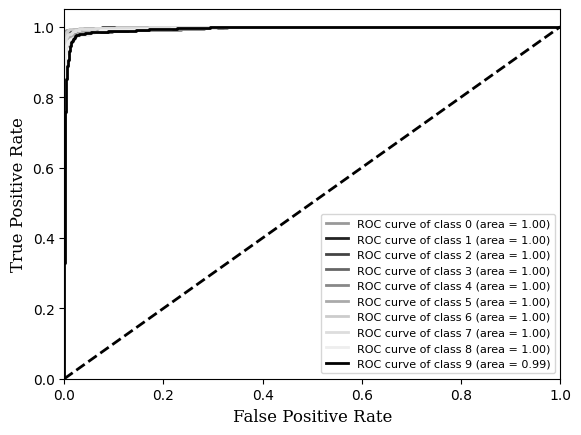

In [9]:

with torch.no_grad():
    y_true = []
    y_scores = []
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    csfont = {'fontname':'serif'}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, np.array(y_scores)[:, i], pos_label=i)

        # Compute ROC AUC for each class
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure()
    #colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'black', 'gray', 'brown', 'olive']
    #colors = ['#000000', '#222222', '#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC', '#DDDDDD', '#EEEEEE', '#FFFFFF']
    colors = ['#999999', '#222222', '#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC', '#DDDDDD', '#EEEEEE', '#000000']
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=12,**csfont)
    plt.ylabel('True Positive Rate',fontsize=12,**csfont)
    plt.legend(loc="lower right",fontsize=8)
    plt.savefig('Data\plot_roc_digit.pdf')
    plt.show()



<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
C:\Users\aswathyr\AppData\Local\Temp\ipykernel_28612\1401938944.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.savefig('Data\plot_roc_digit_zoomed.pdf')


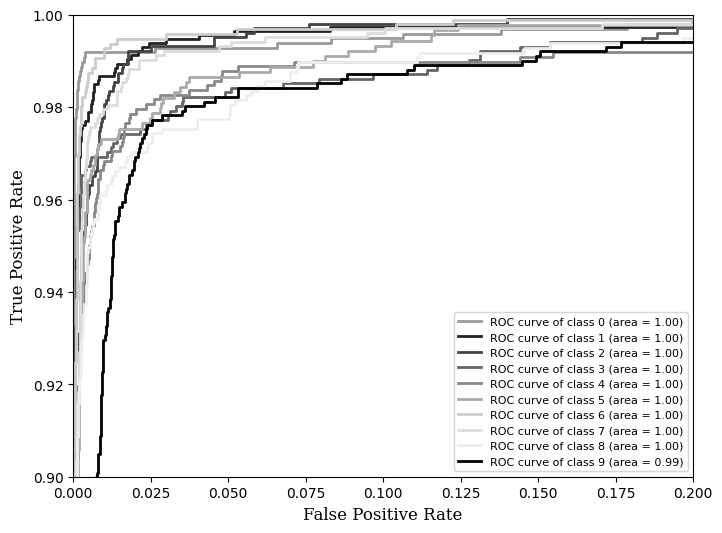

In [10]:
# Zoom in on the ROC curve by specifying custom x and y limits
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 0.2])  # Customize the x-axis limits
plt.ylim([0.9, 1.0])  # Customize the y-axis limits
plt.xlabel('False Positive Rate', fontsize=12, **csfont)
plt.ylabel('True Positive Rate', fontsize=12, **csfont)
plt.legend(loc="lower right", fontsize=8)
plt.savefig('Data\plot_roc_digit_zoomed.pdf')
plt.show()